# Import libraries

In [34]:
%pylab inline
import numpy as np
np.random.seed(2016)
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import sys, os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.preprocessing import image
split_random_state = 7
split = .8

Populating the interactive namespace from numpy and matplotlib


C:\Users\100641313\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'sqrt', 'split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Training dataset

In [35]:
def load_numeric_training(standardize=True):
    #read data from CSV file
    data = pd.read_csv('train.csv')
    ID = data.pop('id')
    #print(ID)
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    X = StandardScaler().fit(data).transform(data) if standardize else data.values
    return ID, y
ID, y = load_numeric_training()
y.shape
y = to_categorical(y)
y.shape

(990, 99)

# Test Dataset

In [44]:
def load_numeric_test(standardize=True):
    #read data from CSV file
    test = pd.read_csv('test.csv')
    t_ID = test.pop('id')
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return t_ID, test
t_ID, test = load_numeric_test()
test = to_categorical(test)
t_ID.shape

(594,)

# Resize Image

In [6]:
def resize_img(img, max_dim=96):
       
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    # The below code just makes sure that the proportional dimensions remain the same. 
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))

# Load image data

In [38]:
def load_image_data(ids, max_dim=96, center=True):
   
    # Initialize and empty output array, 
    X = np.empty((len(ids), max_dim, max_dim, 1))
    
    
    for i, idee in enumerate(ids):
       
        x = resize_img(load_img(os.path.join('images/', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        # img to array is an existing method part of keras.
        # img has been resized but it has to put into array format. 
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        length = x.shape[0]
        width = x.shape[1]
        if center:
            # have to put into integer for shape to understand. 
            # This is the code to position it to center
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            # Now it will be left in the hoek
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        X[i, h1:h2, w1:w2, 0:1] = x
       
    # Scale the array values so they are between 0 and 1
    # It then rounds to a certain amount of decimals. 
       
    return np.around(X / 255.0)
X = load_image_data(ID)
X.shape

(990, 96, 96, 1)

# Cross validation on training data

In [39]:
def load_train_data(split=split, random_state=None):
       
    # Load the pre-extracted features
    ID, y = load_numeric_training()
    # Load the image data
    X = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, val_ind = next(sss.split(X, y))    
    xTrain, yTrain = X[train_ind], y[train_ind]
    xVal, yVal = X[val_ind], y[val_ind]
   
    return (xTrain, yTrain), (xVal, yVal)

In [9]:
(xTrain, yTrain), (xVal, yVal) = load_train_data(random_state=split_random_state)
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(792, 96, 96, 1)
(792,)
(99, 96, 96, 1)
(99,)


In [10]:
print('Loading the training data...')
(xTrain, yTrain), (xVal, yVal) =load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(yTrain)
y_val_cat = to_categorical(yVal)
print('Training data loaded!')
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

Loading the training data...
Training data loaded!
(792, 96, 96, 1)
(792,)
(99, 96, 96, 1)
(99,)


In [107]:
def load_test_data():   
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te
ID, X_num_te, X_img_te =load_test_data()
X_img_te.shape

(594, 96, 96, 1)

# Model Creation

In [13]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge
from keras.layers.core import Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import RMSprop



meanX = X.mean().astype(np.float32)
stdX = X.std().astype(np.float32)

def normalize(x): 
    return (x-meanX)/stdX

def enrich(x):
    #take a flattened image array and add the additional parameters
    return ('foo')

model = Sequential([
    Lambda(normalize, input_shape=(96,96,1)),
        Convolution2D(8, 5, 5, activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Convolution2D(32, 5, 5, activation='relu'),
        ZeroPadding2D((1, 1)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(99, activation='softmax')
    ])

opt = RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



C:\Users\100641313\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), activation="relu")`
C:\Users\100641313\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu")`


# Train Model

In [14]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
batch_size =64

# autosave best Model
best_model_file = "leafnet2.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

generator = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, 
                                     height_shift_range=0.08, zoom_range=0.08)
trainBatches = generator.flow(xTrain, y_tr_cat, batch_size=batch_size)
valBatches = generator.flow(xVal, y_val_cat, batch_size=batch_size)

history = model.fit_generator(trainBatches, trainBatches.n, nb_epoch=100, 
                    validation_data=valBatches, nb_val_samples=valBatches.n)


print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')




C:\Users\100641313\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
C:\Users\100641313\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., 792, validation_data=<keras.pre..., epochs=100, validation_steps=99)`
  from ipykernel import kernelapp as app


Epoch 1/100
792/792 [==============================] - 1026s - loss: 3.0112 - acc: 0.2359 - val_loss: 2.4088 - val_acc: 0.3440
Epoch 2/100
792/792 [==============================] - 1019s - loss: 1.8549 - acc: 0.4387 - val_loss: 1.9762 - val_acc: 0.4380
Epoch 3/100
792/792 [==============================] - 1038s - loss: 1.5412 - acc: 0.5188 - val_loss: 1.7943 - val_acc: 0.4871
Epoch 4/100
792/792 [==============================] - 967s - loss: 1.3450 - acc: 0.5702 - val_loss: 1.6699 - val_acc: 0.5237
Epoch 5/100
792/792 [==============================] - 427s - loss: 1.1881 - acc: 0.6187 - val_loss: 1.5955 - val_acc: 0.5438
Epoch 6/100
792/792 [==============================] - 449s - loss: 1.0675 - acc: 0.6562 - val_loss: 1.5167 - val_acc: 0.5780
Epoch 7/100
792/792 [==============================] - 437s - loss: 0.9720 - acc: 0.6839 - val_loss: 1.4884 - val_acc: 0.5803
Epoch 8/100
792/792 [==============================] - 422s - loss: 0.8872 - acc: 0.7082 - val_loss: 1.4057 - val_a

792/792 [==============================] - 406s - loss: 0.1164 - acc: 0.9596 - val_loss: 1.0991 - val_acc: 0.7851
Epoch 66/100
792/792 [==============================] - 407s - loss: 0.1127 - acc: 0.9610 - val_loss: 1.1055 - val_acc: 0.7820
Epoch 67/100
792/792 [==============================] - 406s - loss: 0.1066 - acc: 0.9638 - val_loss: 1.0944 - val_acc: 0.7833
Epoch 68/100
792/792 [==============================] - 407s - loss: 0.1080 - acc: 0.9615 - val_loss: 1.0888 - val_acc: 0.7876
Epoch 69/100
792/792 [==============================] - 406s - loss: 0.1010 - acc: 0.9649 - val_loss: 1.1227 - val_acc: 0.7835
Epoch 70/100
792/792 [==============================] - 408s - loss: 0.1035 - acc: 0.9649 - val_loss: 1.1144 - val_acc: 0.7816
Epoch 71/100
792/792 [==============================] - 408s - loss: 0.0989 - acc: 0.9655 - val_loss: 1.1505 - val_acc: 0.7768
Epoch 72/100
792/792 [==============================] - 412s - loss: 0.0978 - acc: 0.9662 - val_loss: 1.0726 - val_acc: 0.78

OSError: Unable to open file (Unable to open file: name = 'leafnet2.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [15]:
#y_tr_cat.shape
print('val_acc: ',max(history.history['val_acc']))
print('val_loss: ',min(history.history['val_loss']))
print('train_acc: ',max(history.history['acc']))
print('train_loss: ',min(history.history['loss']))

print()
print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

val_acc:  0.805976262748
val_loss:  0.993863867401
train_acc:  0.975397943867
train_loss:  0.0730303285847

train/val loss ratio:  0.0734812190885


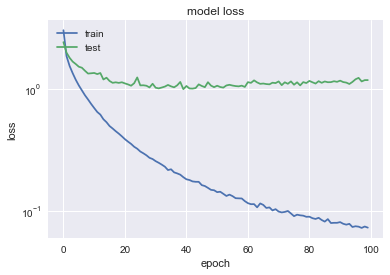

In [16]:
#xTrain.shape
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

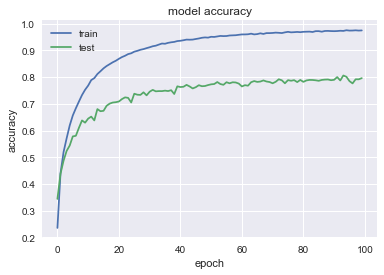

In [17]:
#xVal.shape
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
# Get the names of the column headers
LABELS = sorted(pd.read_csv("train.csv").species.unique())

index, test, X_img_te = load_test_data()

yPred_proba = model.predict([X_img_te, test])

# Converting the test predictions in a dataframe as depicted by sample submission
yPred = pd.DataFrame(yPred_proba,index=index,columns=LABELS)

print('Creating and writing submission...')
fp = open('submit2.csv', 'w')
fp.write(yPred.to_csv())
print('Finished writing submission')
# Display the submission
yPred.head()
print(X_img_te.shape)
print(test.shape)

Creating and writing submission...
Finished writing submission
(594, 96, 96, 1)
(594, 192)


In [31]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Binarize the output
y.shape
y = label_binarize(y, classes=list(range(99)))
n_classes = y.shape[1]
n_classes
random_state = np.random.RandomState(0)


classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
y_score = classifier.fit(X_img_te, y_testing).decision_function(X_img_te)

Automatically created module for IPython interactive environment


In [130]:
# Plot data
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)

In [ ]:
print('Predicting on test data')
y_score = model.predict([xVal, test])
print('Generating results')
print(y_score.shape)
generate_results(y_val_cat[:, 1], y_score[:, 1])

Predicting on test data
Generating results
(99, 99)


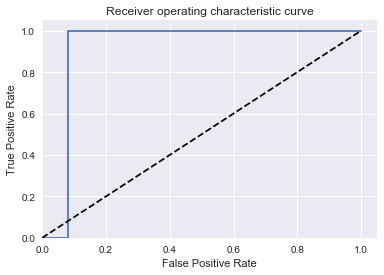

AUC: 0.918367


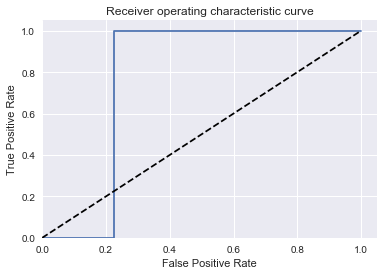

AUC: 0.775510


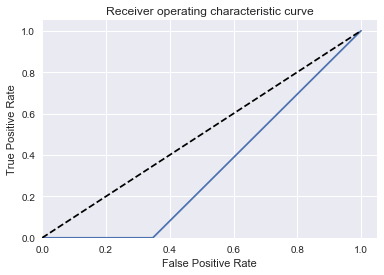

AUC: 0.326531


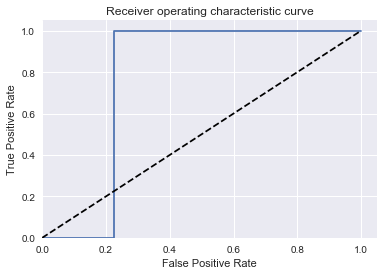

AUC: 0.775510


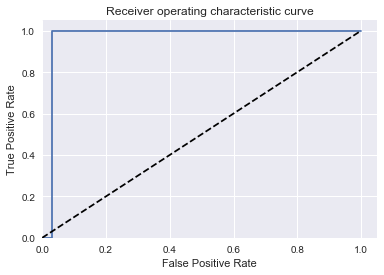

AUC: 0.969388


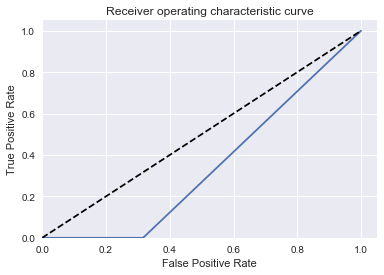

AUC: 0.341837


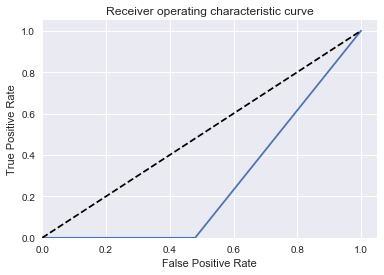

AUC: 0.260204


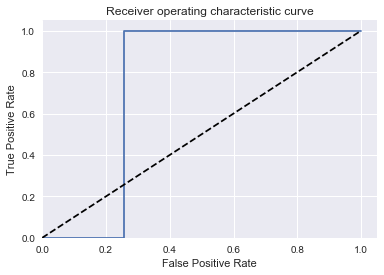

AUC: 0.744898


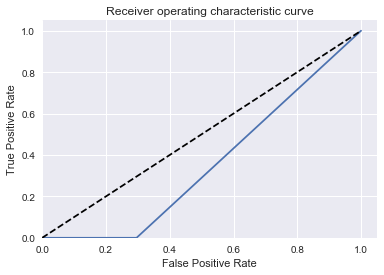

AUC: 0.352041


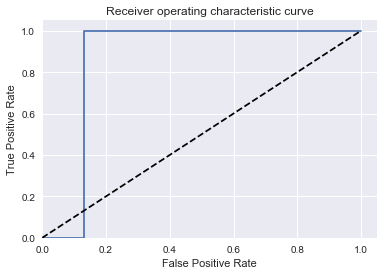

AUC: 0.867347


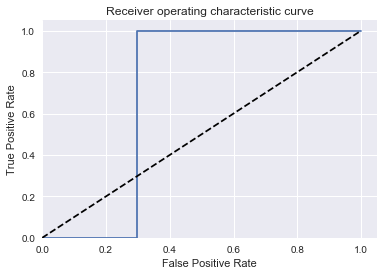

AUC: 0.704082


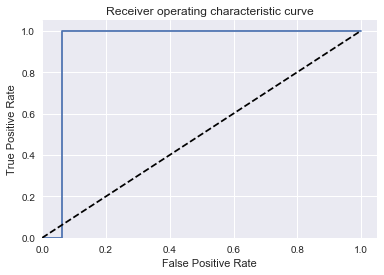

AUC: 0.938776


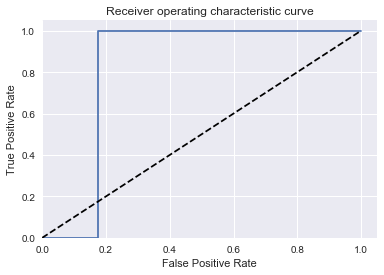

AUC: 0.826531


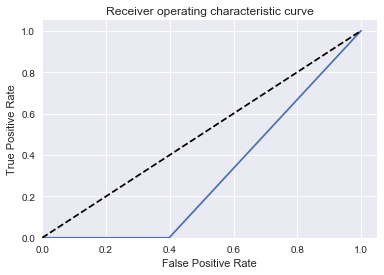

AUC: 0.301020


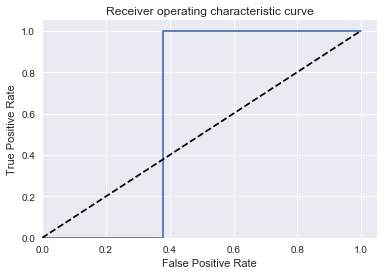

AUC: 0.622449


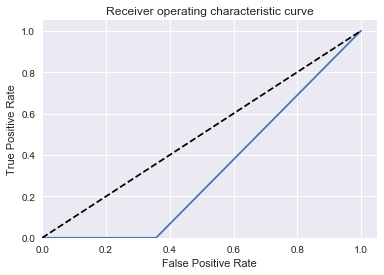

AUC: 0.321429


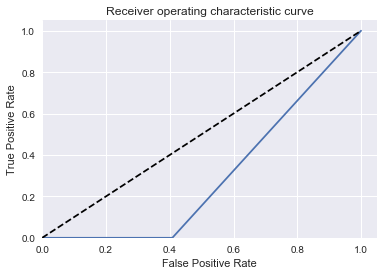

AUC: 0.295918


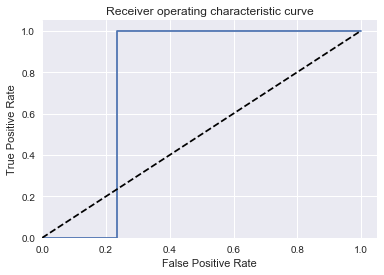

AUC: 0.765306


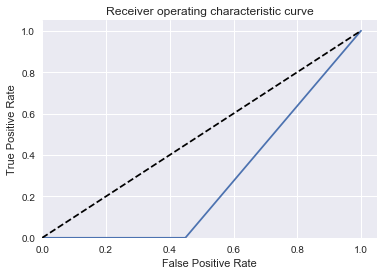

AUC: 0.275510


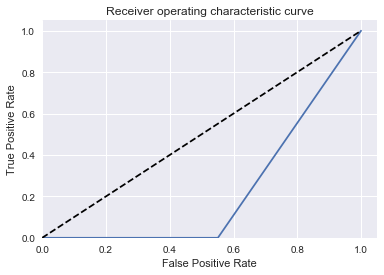

AUC: 0.224490


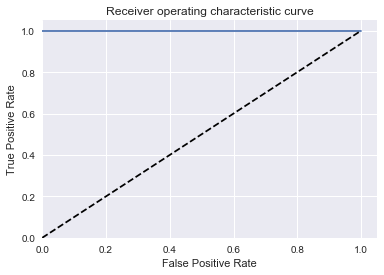

AUC: 1.000000


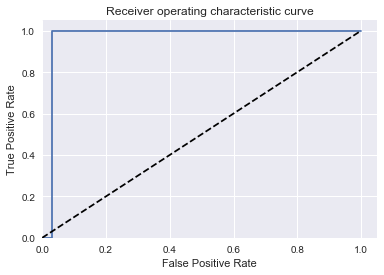

AUC: 0.969388


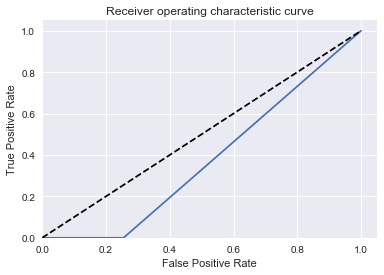

AUC: 0.372449


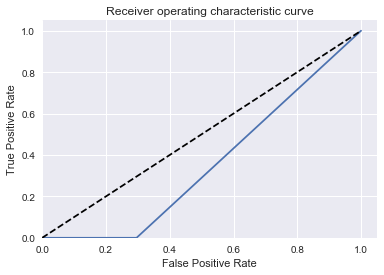

AUC: 0.352041


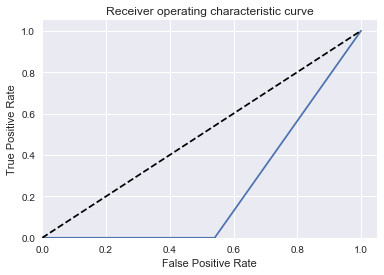

AUC: 0.229592


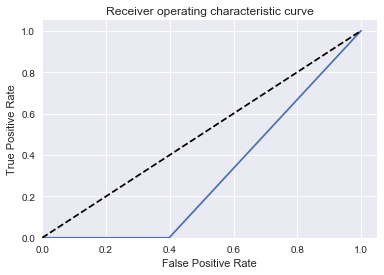

AUC: 0.301020


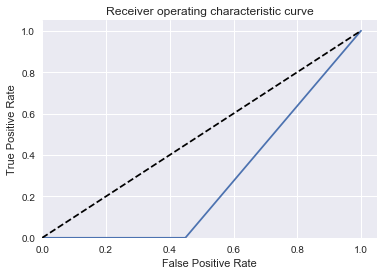

AUC: 0.275510


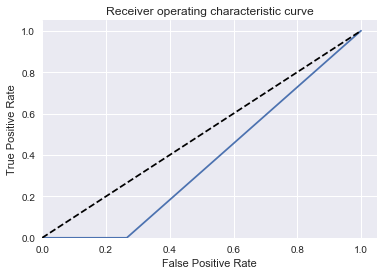

AUC: 0.367347


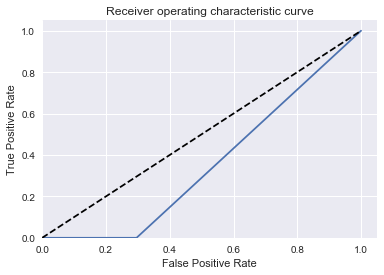

AUC: 0.352041


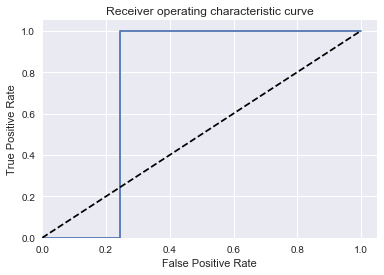

AUC: 0.755102


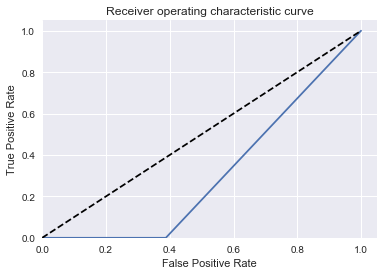

AUC: 0.306122


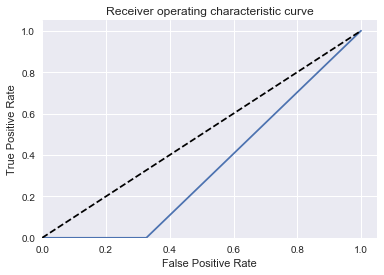

AUC: 0.336735


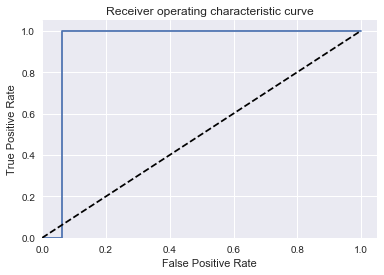

AUC: 0.938776


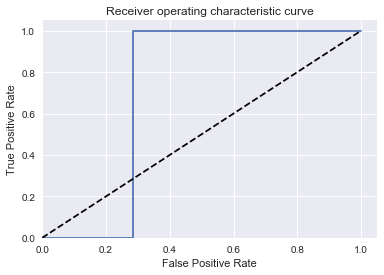

AUC: 0.714286


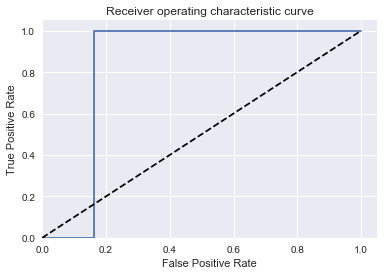

AUC: 0.836735


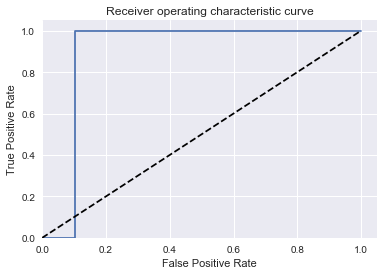

AUC: 0.897959


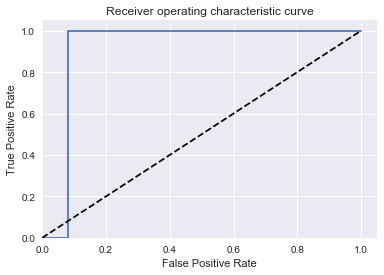

AUC: 0.918367


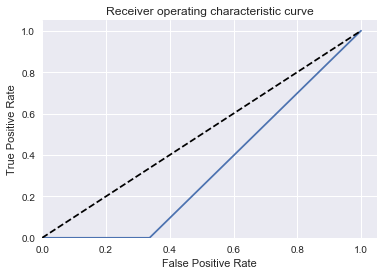

AUC: 0.331633


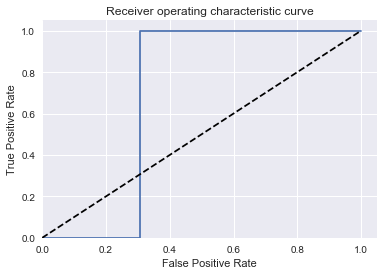

AUC: 0.693878


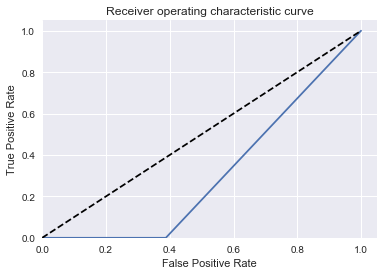

AUC: 0.306122


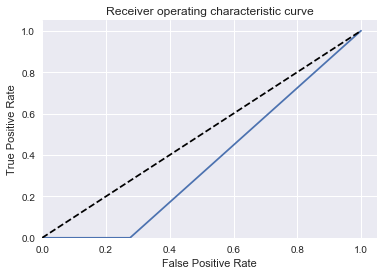

AUC: 0.362245


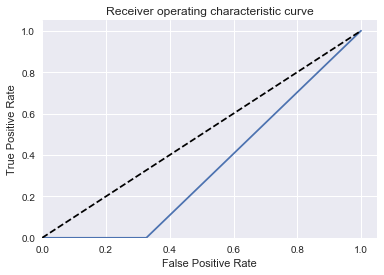

AUC: 0.336735


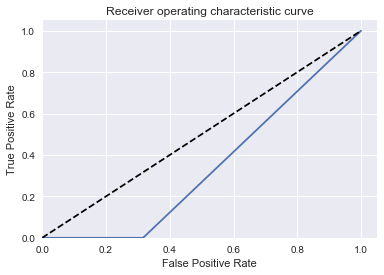

AUC: 0.341837


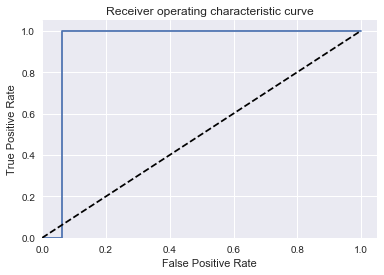

AUC: 0.938776


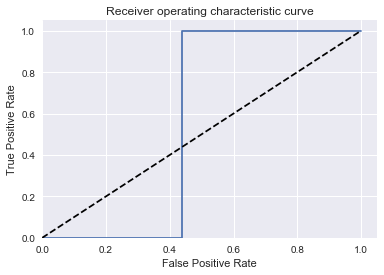

AUC: 0.561224


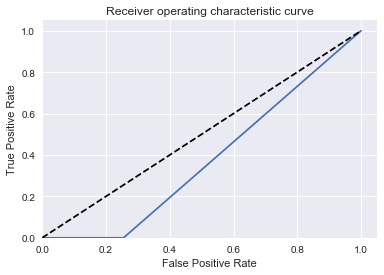

AUC: 0.372449


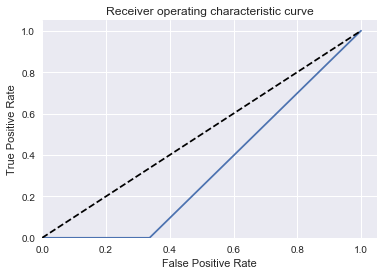

AUC: 0.331633


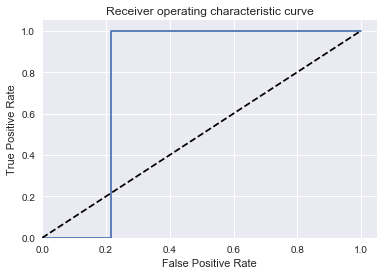

AUC: 0.785714


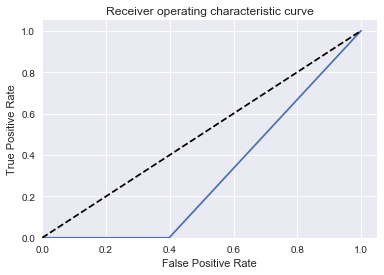

AUC: 0.301020


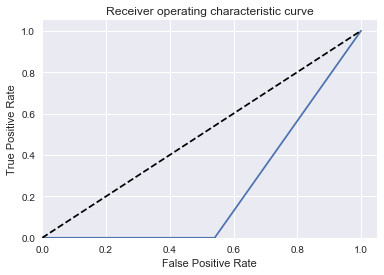

AUC: 0.229592


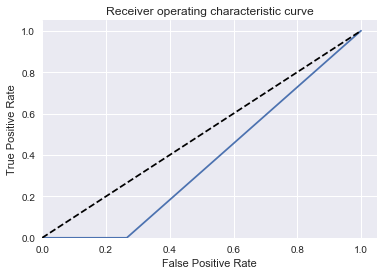

AUC: 0.367347


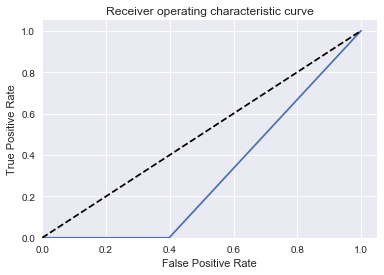

AUC: 0.301020


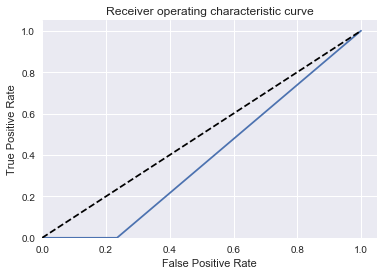

AUC: 0.382653


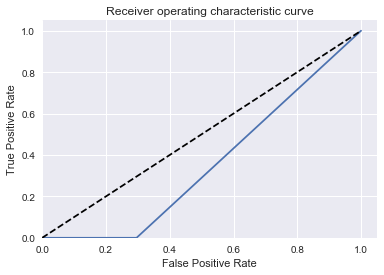

AUC: 0.352041


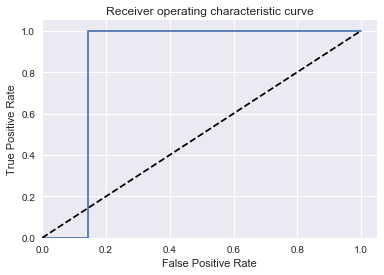

AUC: 0.857143


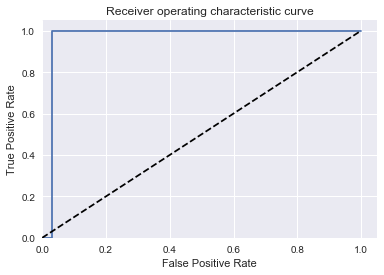

AUC: 0.969388


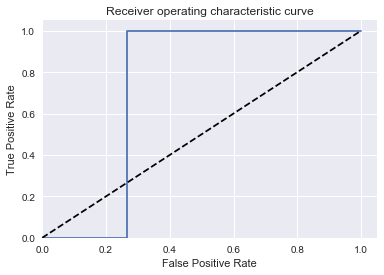

AUC: 0.734694


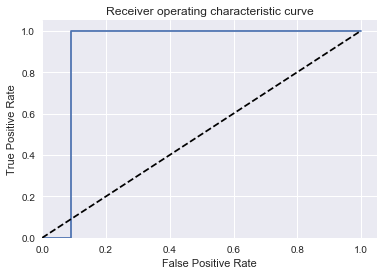

AUC: 0.908163


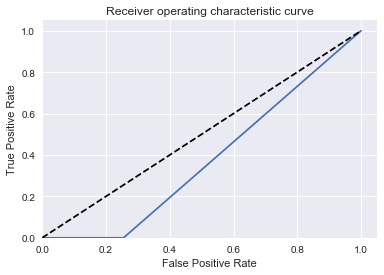

AUC: 0.372449


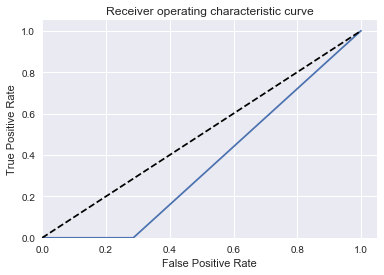

AUC: 0.357143


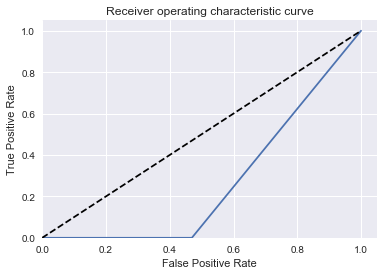

AUC: 0.265306


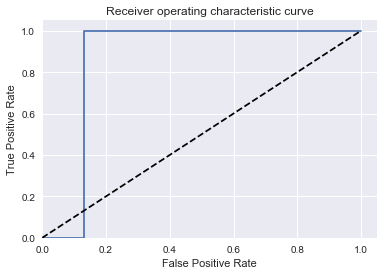

AUC: 0.867347


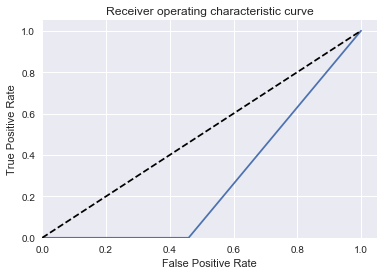

AUC: 0.270408


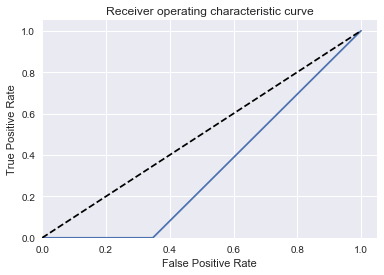

AUC: 0.326531


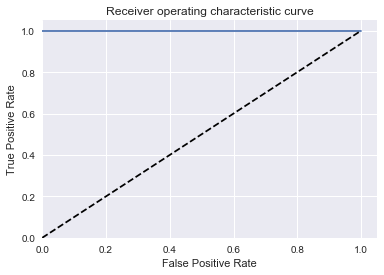

AUC: 1.000000


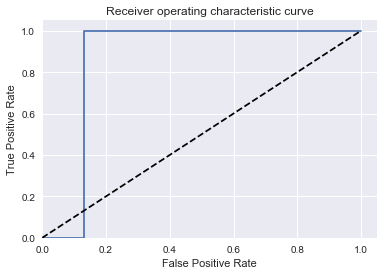

AUC: 0.867347


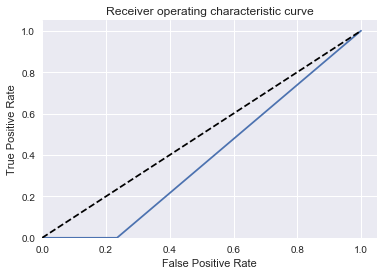

AUC: 0.382653


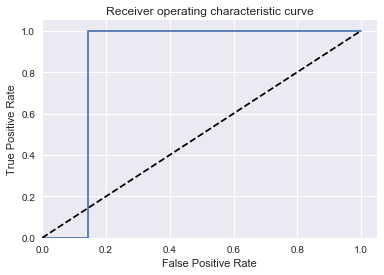

AUC: 0.857143


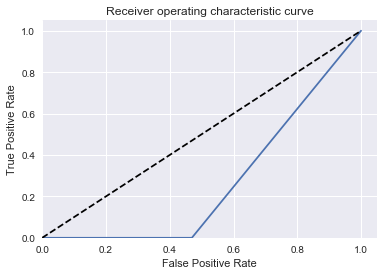

AUC: 0.265306


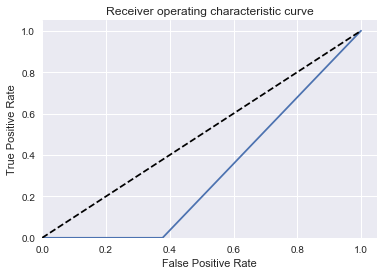

AUC: 0.311224


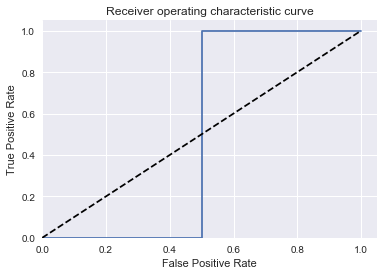

AUC: 0.500000


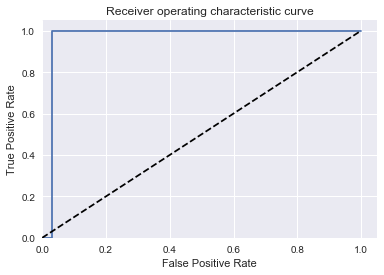

AUC: 0.969388


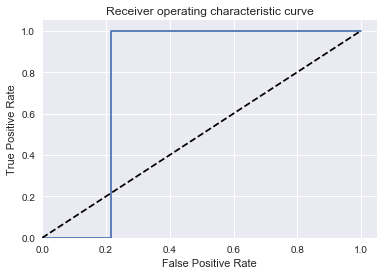

AUC: 0.785714


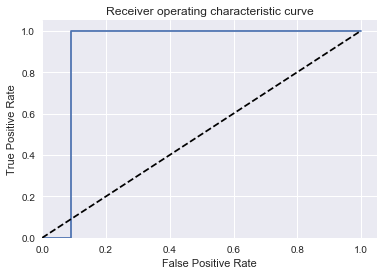

AUC: 0.908163


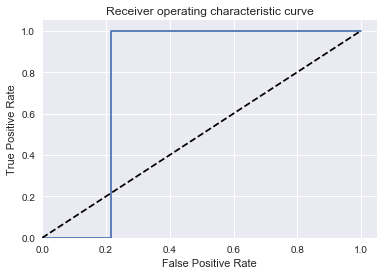

AUC: 0.785714


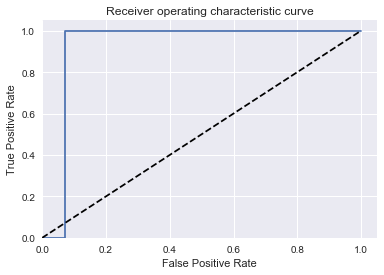

AUC: 0.928571


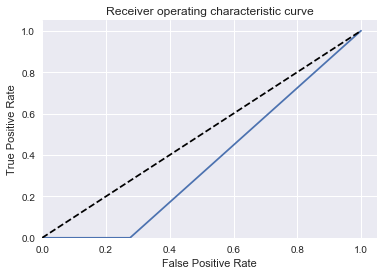

AUC: 0.362245


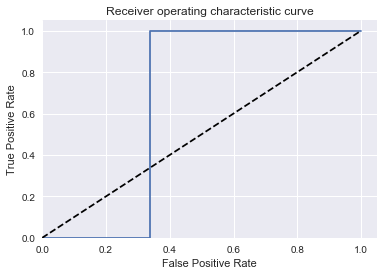

AUC: 0.663265


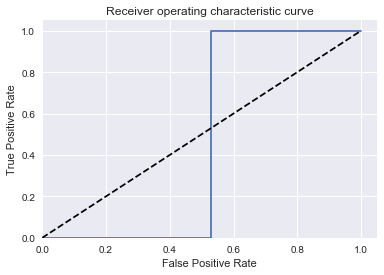

AUC: 0.469388


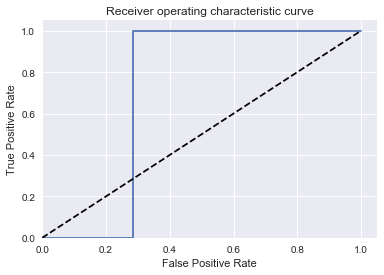

AUC: 0.714286


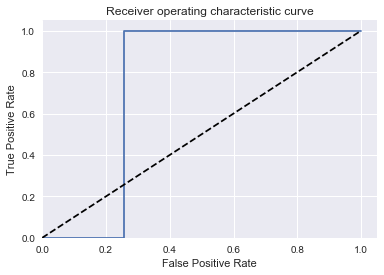

AUC: 0.744898


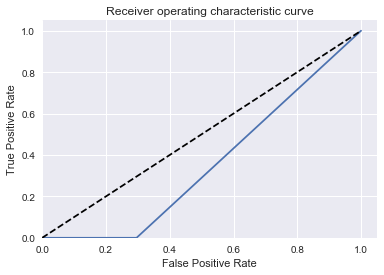

AUC: 0.352041


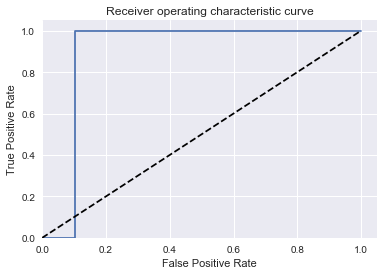

AUC: 0.897959


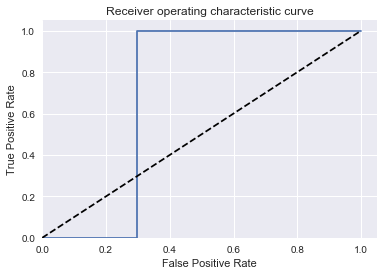

AUC: 0.704082


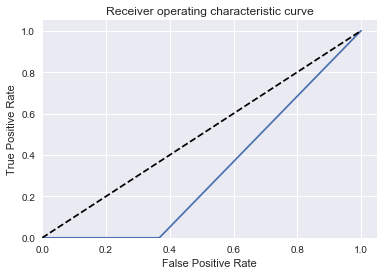

AUC: 0.316327


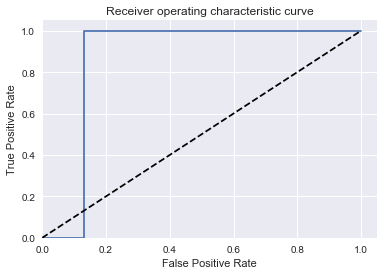

AUC: 0.867347


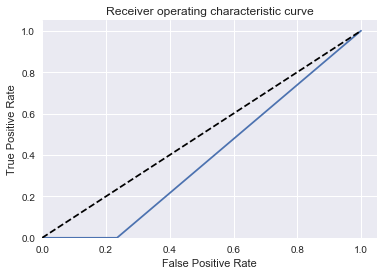

AUC: 0.382653


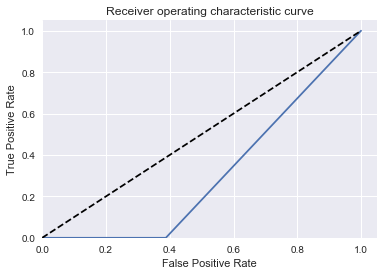

AUC: 0.306122


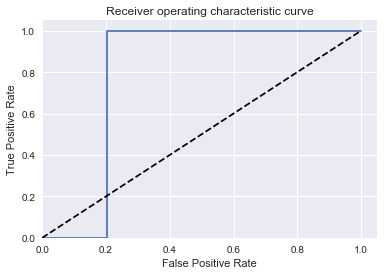

AUC: 0.795918


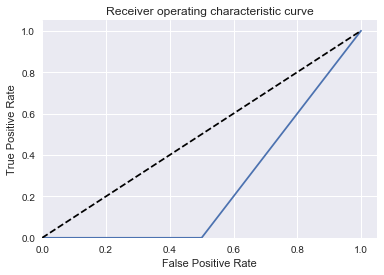

AUC: 0.250000


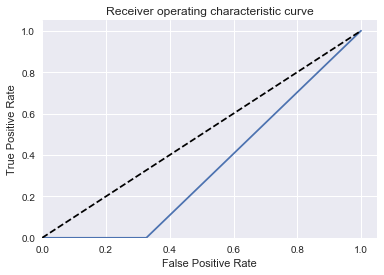

AUC: 0.336735


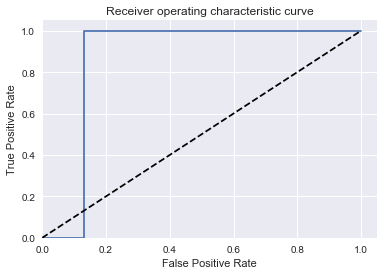

AUC: 0.867347


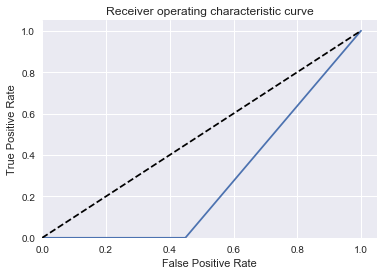

AUC: 0.275510


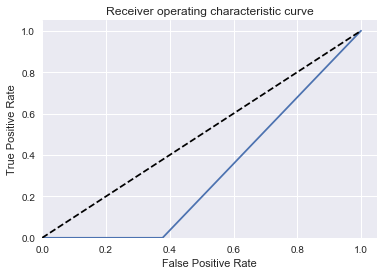

AUC: 0.311224


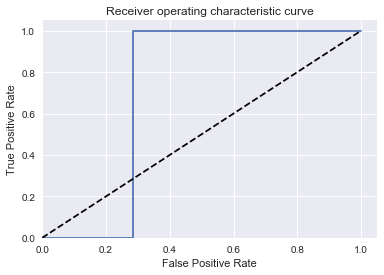

AUC: 0.714286


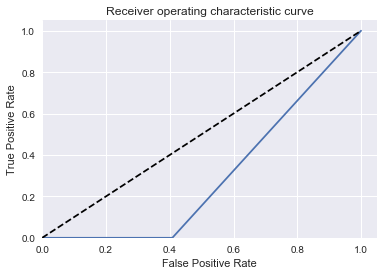

AUC: 0.295918


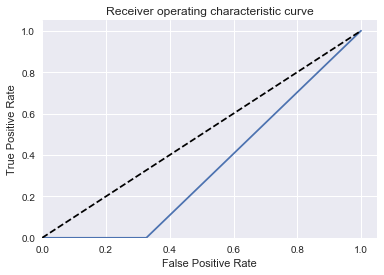

AUC: 0.336735


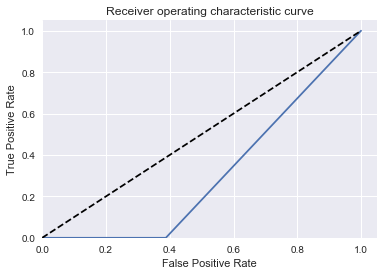

AUC: 0.306122


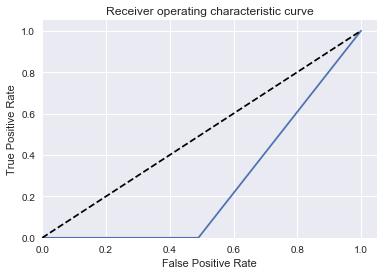

AUC: 0.255102


In [161]:
print('Predicting on test data')
y_score = model.predict([xVal, test])
print('Generating results')
print(y_score.shape)
for i in range(0, 99):
    generate_results(y_val_cat[:, i], y_score[:, i])


In [150]:
y_score[:, 1] = 0

array([  0.00000000e+00,   0.00000000e+00,   6.99999988e-01,
         2.00000003e-01,   1.17995250e-37,   1.00000001e-01,
         1.28296098e-33,   5.26286092e-23,   1.19469057e-37,
         2.15465848e-21,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.35948752e-37,
         0.00000000e+00,   3.92145035e-20,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   1.60649280e-28,
         2.48702190e-32,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   6.08379957e-36,
         0.00000000e+00,   6.04813542e-25,   9.92580377e-33,
         0.00000000e+00,   0.00000000e+00,   2.05614654e-26,
         0.00000000e+00,   3.61554714e-24,   0.00000000e+00,
         2.00379963e-23,   1.58701759e-38,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.56420083e-15,